In [ ]:
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout, BatchNormalization
import numpy as np
import pandas as pd


from matplotlib import pyplot as plt
import os
########################################################################

In [ ]:
from google.colab import drive
gpath = drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/ct scans/'

print(os.listdir(path))

['ct_scan_1.npz', 'ct_scan_2.npz', 'ct_scan_3.npz', 'ct_scan_4.npz', 'ct_scan_5.npz', 'ct_scan_6.npz', 'ct_scan_7.npz', 'ct_scan_8.npz', 'history.csv', 'ct_scan_discriminator.h5', 'ct_scan_generator.h5', 'gt', 'bladder_segmentation_unet.hdf5']


In [ ]:
i = 0
for npz_name in os.listdir(path):

  complete_address = os.path.join(path,npz_name)

  file_extension = complete_address.split(".")[-1]

  if file_extension == "npz":


    ct_scans = np.load(complete_address)

    if i == 0:
      complete_array = ct_scans["arr_0"]

      complete_array = np.transpose(complete_array, (1,2,0))
      pass

    if i > 0:

      ct_scan_array = ct_scans["arr_0"]

      if ct_scan_array.shape[0] != 256:

        ct_scan_array = np.transpose(ct_scan_array, (1,2,0))
        pass


      complete_array = np.concatenate((complete_array, ct_scan_array),axis=2)

      print(ct_scan_array.shape)

      pass

    pass

  i = i + 1

  pass



(256, 256, 60)
(256, 256, 63)
(256, 256, 63)
(256, 256, 63)
(256, 256, 63)
(256, 256, 63)
(256, 256, 57)


In [ ]:
print(complete_array.shape)

(256, 256, 489)


In [ ]:
print(np.max(complete_array))

3441.0


In [ ]:
dataset_list = []

for i in range(complete_array.shape[2]):

  dataset_list.append(np.expand_dims(complete_array[:,:,i], axis = 2))

  pass

In [ ]:
print(np.array(dataset_list).shape)

(489, 256, 256, 1)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
for i in range(len(dataset_list)):


  dataset_list[i] = scaler.fit_transform(dataset_list[i].reshape(-1, dataset_list[i].shape[-1])).reshape(dataset_list[i].shape)


  pass

In [ ]:
print(np.array(dataset_list).shape)

(489, 256, 256, 1)


In [ ]:
dataset = np.array(dataset_list)

### ***GAN***

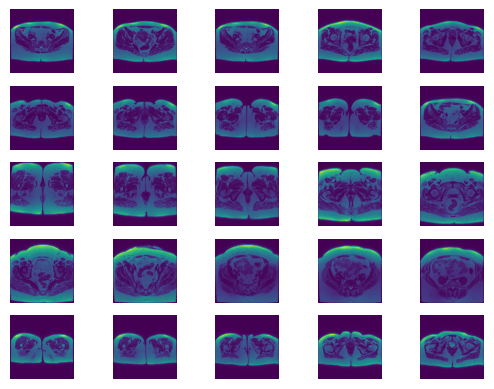

In [ ]:
# plot 25 images
for i in range(25):
	plt.subplot(5, 5, 1 + i)
	plt.axis('off')
	plt.imshow(dataset[i*6])
plt.show()

***Discriminator***

In [ ]:
# define the standalone discriminator model
#Given an input image, the Discriminator outputs the likelihood of the image being real.
#Binary classification - true or false (1 or 0). So using sigmoid activation.
def define_discriminator(in_shape=(256,256,1)):
	model = Sequential()

	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape)) #16x16x128
	model.add(LeakyReLU(alpha=0.2))

	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same')) #8x8x128
	model.add(LeakyReLU(alpha=0.2))

	model.add(Flatten()) #shape of 8192
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid')) #shape of 1
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

test_discr = define_discriminator()
print(test_discr.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 128)     1280      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 128)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 flatten (Flatten)           (None, 524288)            0         
                                                                 
 dropout (Dropout)           (None, 524288)            0         
                                                                 
 dense (Dense)               (None, 1)                 5

***Generator***

In [ ]:
def define_generator(latent_dim):    #latent_dim is the dimension of the latent vector (e.g., 100)
	model = Sequential()
	# We will reshape input latent vector into 8x8 image as a starting point.
    #So n_nodes for the Dense layer can be 128x8x8 so when we reshape the output
    #it would be 8x8x128 and that can be slowly upscaled to 32x32 image for output.
	n_nodes = 128 * 32 * 32  #8192 nodes
	model.add(Dense(n_nodes, input_dim=latent_dim)) #Dense layer so we can work with 1D latent vector
	model.add(LeakyReLU(alpha=0.2))

	#model.add(BatchNormalization())

	model.add(Reshape((32, 32, 128)))  #8x8x128 dataset from the latent vector.

  # upsample to 64x64
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #128x128x128
	model.add(LeakyReLU(alpha=0.2))
	#model.add(BatchNormalization())
	# upsample to 128x128
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #128x128x128
	model.add(LeakyReLU(alpha=0.2))
	#model.add(BatchNormalization())
	# upsample to 256x256
	model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same')) #256x256x128
	model.add(LeakyReLU(alpha=0.2))
	#model.add(BatchNormalization())
	# generate
	model.add(Conv2D(1, (8,8), activation='tanh', padding='same')) #256x256x1
	return model  #Model not compiled as it is not directly trained like the discriminator.
                    #Generator is trained via GAN combined model.

test_gen = define_generator(100)
print(test_gen.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 131072)            13238272  
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 131072)            0         
                                                                 
 reshape (Reshape)           (None, 32, 32, 128)       0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 64, 64, 128)       262272    
 anspose)                                                        
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 128, 128, 128)     262272    
 Transpose)                                           

In [ ]:
def define_gan(generator, discriminator):
	discriminator.trainable = False  #Discriminator is trained separately. So set to not trainable.
	# connect generator and discriminator
	model = Sequential()
	model.add(generator)
	model.add(discriminator)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

***Normalization***

In [ ]:
def load_real_samples(input_dataset):

	# cConvert to float and scale.
	#X = input_dataset.astype('float32')
	# scale from [0,255] to [-1,1]
	#X = (X - (np.max(X)/2)) / (np.max(X)/2)  #Generator uses tanh activation so rescale  X = (X - 127.5) / 127.5
                            #original images to -1 to 1 to match the output of generator.
	return input_dataset #X

In [ ]:
normalized_dataset = load_real_samples(dataset)

print(normalized_dataset.shape)

print(np.max(normalized_dataset))

(489, 256, 256, 1)
1.0


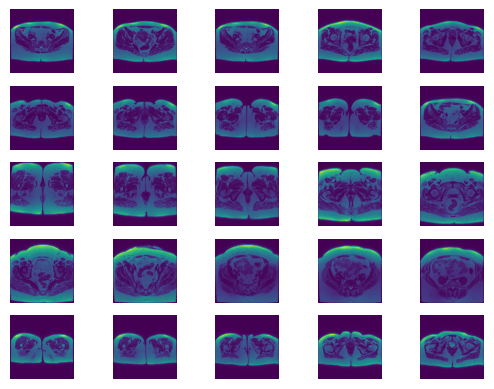

In [ ]:
# plot 25 images
for i in range(25):
	plt.subplot(5, 5, 1 + i)
	plt.axis('off')
	plt.imshow(normalized_dataset[i*6])
plt.show()

In [ ]:
def generate_real_samples(dataset, n_samples):
	# choose random images
	ix = randint(0, dataset.shape[0], n_samples)
	# select the random images and assign it to X
	X = dataset[ix]
	# generate class labels and assign to y
	y = ones((n_samples, 1)) ##Label=1 indicating they are real
	return X, y

In [ ]:
X_real, y_real = generate_real_samples(normalized_dataset, 245)

In [ ]:
print(X_real.shape)

(245, 256, 256, 1)


In [ ]:
# generate n_samples number of latent vectors as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [ ]:
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict using generator to generate fake samples.
	X = generator.predict(x_input)
	# Class labels will be 0 as these samples are fake.
	y = zeros((n_samples, 1))  #Label=0 indicating they are fake
	return X, y

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)  #the discriminator model is updated for a half batch of real samples
                            #and a half batch of fake samples, combined a single batch.

	#df = pd.read_csv("/content/drive/MyDrive/ct scans/history.csv")

	#readings = df.values.tolist()
	readings = []
	# manually enumerate epochs and bacthes.
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):

            # Train the discriminator on real and fake images, separately (half batch each)
        #Research showed that separate training is more effective.
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
            ##train_on_batch allows you to update weights based on a collection
            #of samples you provide
            #Let us just capture loss and ignore accuracy value (2nd output below)
			d_loss_real, _ = d_model.train_on_batch(X_real, y_real)

            # generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)

            #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) #Average loss if you want to report single..

			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)

            # The generator wants the discriminator to label the generated samples
        # as valid (ones)
        #This is where the generator is trying to trick discriminator into believing
        #the generated image is true (hence value of 1 for y)
			y_gan = ones((n_batch, 1))

            # Generator is part of combined model where it got directly linked with the discriminator
        # Train the generator with latent_dim as x and 1 as y.
        # Again, 1 as the output as it is adversarial and if generator did a great
        #job of folling the discriminator then the output would be 1 (true)
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)

            # Print losses on this batch
			print('Epoch>%d, Batch %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))

			readings.append([i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss])

			dataframe = pd.DataFrame(readings, columns =['Epoch', 'Batch','Batch per Epoch','discriminator_loss_real','discriminator_loss_fake','generator_loss'])

			#dataframe.to_csv("/content/drive/MyDrive/ct scans/history.csv",index=False)
		#g_model.save('/content/drive/MyDrive/ct scans/ct_scan_generator.h5')
		#d_model.save('/content/drive/MyDrive/ct scans/ct_scan_discriminator.h5')
	# save the generator model
	g_model.save('ct_scan_generator.h5')

In [ ]:
dataset = np.array(dataset_list)

In [ ]:
from keras.models import load_model

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator

discriminator = define_discriminator()

#discriminator = load_model('/content/drive/MyDrive/ct scans/ct_scan_discriminator.h5')
# create the generator

generator = define_generator(latent_dim)

#generator = load_model('/content/drive/MyDrive/ct scans/ct_scan_generator.h5')
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
normalized_dataset = load_real_samples(dataset)
# train model
train(generator, discriminator, gan_model, normalized_dataset, latent_dim, n_epochs=150, n_batch=128)

2/2 [==============================] - 0s 126ms/step
Epoch>1, Batch 1/3, d1=0.696, d2=0.713 g=1.270
2/2 [==============================] - 0s 120ms/step
Epoch>1, Batch 2/3, d1=0.027, d2=0.559 g=2.644
2/2 [==============================] - 0s 120ms/step
Epoch>1, Batch 3/3, d1=0.015, d2=0.712 g=9.786
2/2 [==============================] - 0s 122ms/step
Epoch>2, Batch 1/3, d1=10.172, d2=0.049 g=1.952
2/2 [==============================] - 0s 123ms/step
Epoch>2, Batch 2/3, d1=0.000, d2=0.221 g=2.072
2/2 [==============================] - 0s 121ms/step
Epoch>2, Batch 3/3, d1=0.000, d2=0.130 g=2.753
2/2 [==============================] - 0s 122ms/step
Epoch>3, Batch 1/3, d1=0.000, d2=0.537 g=3.596
2/2 [==============================] - 0s 126ms/step
Epoch>3, Batch 2/3, d1=0.001, d2=3.431 g=12.399
2/2 [==============================] - 0s 123ms/step
Epoch>3, Batch 3/3, d1=9.105, d2=0.055 g=1.375
2/2 [==============================] - 0s 124ms/step
Epoch>4, Batch 1/3, d1=0.218, d2=1.383 g=0.92

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch>150, Batch 3/3, d1=0.001, d2=0.000 g=23.631


In [ ]:
# Now, let us load the generator model and generate images

from keras.models import load_model
from numpy.random import randn


# Plot generated images
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	plt.show()


In [ ]:
# load model
#model = load_model('/content/drive/MyDrive/ct scans/ct_scan_generator.h5') #Model trained for 100 epochs
model = load_model('ct_scan_generator.h5') #Model trained for 100 epochs
# generate images
latent_points = generate_latent_points(100, 25)  #Latent dim and n_samples
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

#max_value = np.max(np.array(dataset_list))
#print(max_value)
import numpy as np
#X = (X*max_value).astype(np.uint8)    # X = (X*255).astype(np.uint8)

# plot the result
show_plot(X, 5)

#Note: CIFAR10 classes are: airplane, automobile, bird, cat, deer, dog, frog, horse,
# ship, truck

***frechet inception distance***

In [ ]:
from numpy import cov
from scipy.linalg import sqrtm
import numpy
from numpy import trace
from numpy import iscomplexobj
from numpy.random import random

# calculate frechet inception distance
def calculate_fid(act1, act2):
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = numpy.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid